In this notebook we check the mean signal of the nuclei over the length of the movie. We also check the signal of background from the whole image.

## Load all necessary libraries 

In [56]:
import os
import math
import napari
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nucleiBoxes import *
from dask.array.image import imread
from skimage import io, data

import tkinter as tk
from tkinter import filedialog
from pathlib import Path

In [57]:
def choose_home_folder():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askdirectory(initialdir= "/", title='Please select a directory')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path

def get_session_name():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askopenfile(initialdir= "/", title='Please select movie file')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path

## Specify input and output paths and load image

In [58]:
homeFolder = choose_home_folder()

sessionNames = [i for i in os.listdir(homeFolder) if '_F' in i and os.path.isdir(os.path.join(homeFolder,i))]
sessionNames.sort()


In [59]:
sessionNames

['Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06']

In [60]:
i=0
sessionName = Path(sessionNames[i])
imsQ = sessionName.name.split('_F')[-1]


nameKey = sessionName.name.split('_F')[0]+'_F'


pathToTimeFrames = os.path.join(homeFolder,nameKey+imsQ,'*.tif')
# path_input = os.path.join(homeFolder,nameKey+imsQ+'/cell_'+str(cellNumber)+'/')

movieFolder = os.path.join(homeFolder,nameKey+imsQ)

# 
# MaxTimePoint = np.max([len(os.listdir(os.path.join(homeFolder,sessionName,i))) for i in os.listdir(movieFolder) if "cell_" in i])
timeStack = imread(pathToTimeFrames)
maxImage = np.max(timeStack, axis=1)
MaxTimePoint = maxImage.shape[0]
timeStack

dask.array<imread, shape=(900, 13, 1024, 1024), dtype=uint16, chunksize=(1, 13, 1024, 1024), chunktype=numpy.ndarray>

## Load image segmentation mask

In [61]:
label_image_name = homeFolder+'/tProjections/T_MAX_'+nameKey.replace('.','_')+imsQ+'_cp_masks.png' #T_MAX_'+
label_image = io.imread(label_image_name)

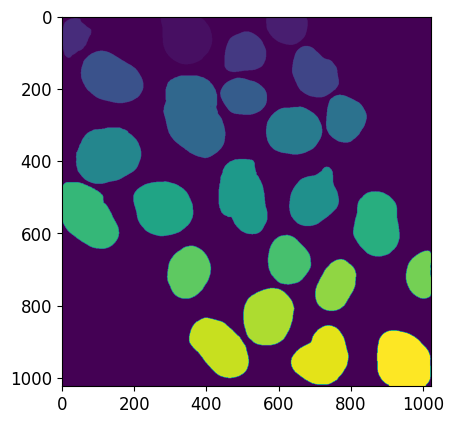

In [62]:
plt.imshow(label_image)

## Draw background region in image 

On running the next cell, a napari viewer will open displaying the image and the segmentation results as well as the bounding box of the nuclei. Follow the steps below to draw a background:
1. Select the layer named "polygon"
2. Select the option Add Rectangle on the top most panel (or press the "R" key on the keyoard)
3. Close the viewer and run next cell with commented line "Get background"

In [63]:
cropBoxCoordinates, nucleiCentroids, nucleiNumbers, _ = getNucleiCoordinates(label_image_name, False)

polygon = []
for nuclei in range(len(cropBoxCoordinates)):
    bx = np.asarray(cropBoxCoordinates[nuclei][0])
    by = np.asarray(cropBoxCoordinates[nuclei][1])
    vertices = []
    for ii in range(len(bx)):
        vertices.append([by[ii], bx[ii]])
    polygon.append(vertices)

features = {
    'N': nucleiNumbers,
}
text = {
    'string': '{N:.1f}',
    'size': 8,
    'color': 'white',
    'translation': np.array([-20, 0]),
}

face_color_cycle = ['white']

viewer = napari.view_image(maxImage, colormap='green')
labels_layer = viewer.add_labels(label_image, name='segmentation',opacity=0.3)
shapes_layer = viewer.add_shapes(polygon, shape_type='polygon', edge_width=2,
                          edge_color='white', face_color='#00000000', opacity=0.3)
points_layer = viewer.add_points(
    nucleiCentroids,
    features=features,
    text=text,
    size=2,
    edge_width=2,
    edge_width_is_relative=False,
    edge_color='N',
    edge_colormap='gray',
    face_color_cycle=face_color_cycle,
    name = 'nuclei Label'
)

## Get background and its bounding box coordinates

In [64]:
# Get background

random_box = shapes_layer.data[-1]

coord=[]
minc = int(np.round(random_box[0][1]))
minr = int(np.round(random_box[0][0]))
maxc = int(np.round(random_box[2][1]))
maxr = int(np.round(random_box[2][0]))

bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
coord.append([bx, by, minc,minr])

with open(homeFolder+"backgrounds.txt", "a") as myfile:
    myfile.write(imsQ+'\t'+str(bx)+'\t'+str(by)+'\n')
myfile.close()
#----------------------------------- For background --------------------------------#

backgroundSignal = getBackgroundTimeProfile(movieFolder, nameKey, imsQ, minc, minr, maxc, maxr, start=0, stop=MaxTimePoint, extensionF='.tif')

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
Saving Crops!

Done!


## Calculate mean signal intensity within nuclei, cytoplasmic, background image

In [65]:
MaxTimePoint

900

In [66]:
cellNumbersFound =[]
for i in next(os.walk(movieFolder))[1]:
    if "cell" in i:
        if len(os.listdir(os.path.join(movieFolder,i))) >= MaxTimePoint:
            cellNumbersFound.append(i.split('cell_')[1])
print(cellNumbersFound)

['11', '12', '14', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


In [67]:
movieFolder

'C:/Users/uid-1204/Desktop/test2_bigFISHLIVE\\Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06'

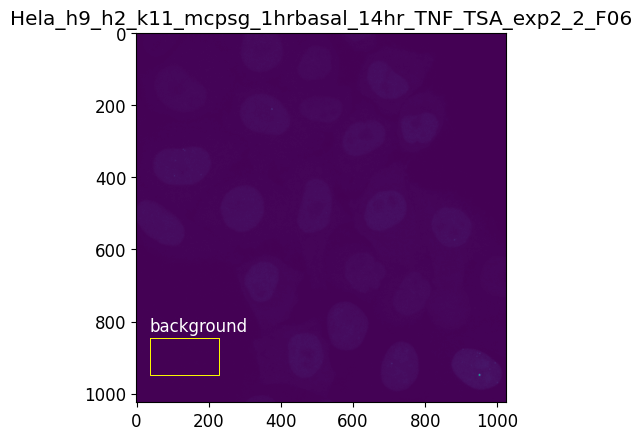

In [68]:
plt.figure(num=25)
plt.imshow(maxImage[0])
plt.text(coord[0][0][0],coord[0][1][1]*0.98, s='background', color='white')
plt.plot(bx, by, linewidth=.7, color='yellow')
plt.title(nameKey+imsQ)
plt.savefig(os.path.join(movieFolder,nameKey+imsQ+'_background.jpg'))

11
12
14
16
17
17
2
3
4
5
6
7
8
9


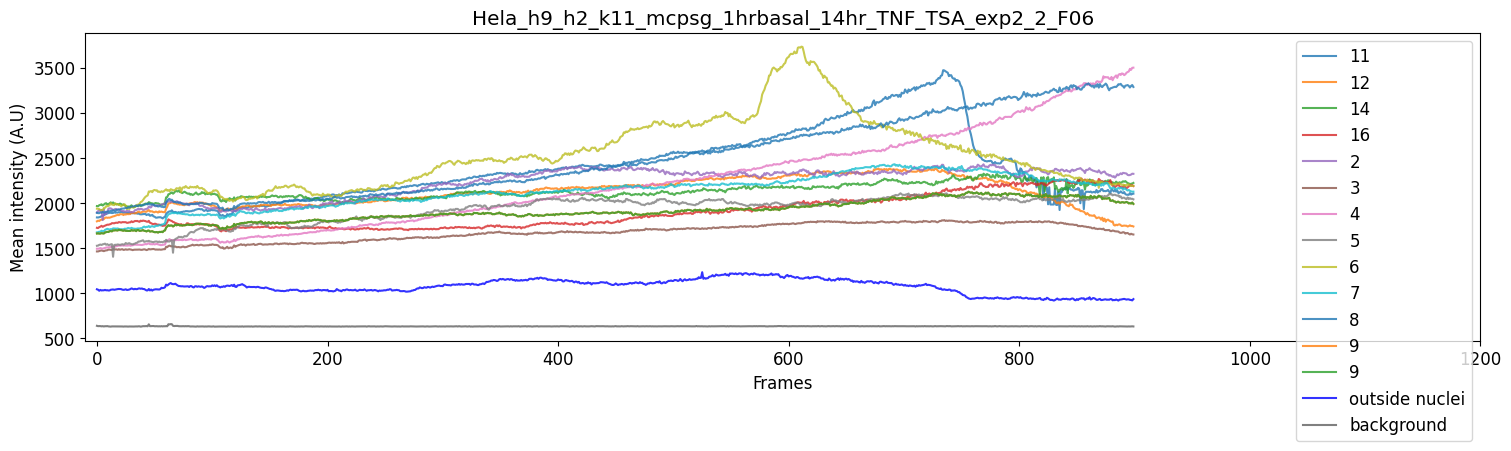

In [69]:
plt.figure(num=4, figsize=(18,4))
plt.rcParams['font.size'] = 12
meanI = []
cid = []
for cellNumber in cellNumbersFound:
    print(cellNumber)
    path_input = os.path.join(homeFolder,nameKey+imsQ,'cell_'+str(cellNumber))
    nucleiStackForm = nameKey+imsQ+"_cell_"
    labeldf = pd.read_pickle(os.path.join(movieFolder,"LabelDF.pkl"))  
    cellImage = imread(os.path.join(path_input,'*.tif'))
    nuclei=np.int64(cellNumber)
    nucIdx = np.where(labeldf['label']==np.int64(nuclei))

    sx = cellImage.shape[2]
    sy = cellImage.shape[3]
    labeldf.iloc[nucIdx[0],10] = sy
    labeldf.iloc[nucIdx[0],9] = sx
    
    try:
        #---------------------------- Within and outside nuclei-----------------------------#
        meanofRandomImageSample_w, meanofRandomImageSample_o = getTimeProfile(path_input, nucleiStackForm, cellNumber, label_image_name, labeldf, 0,MaxTimePoint)

        meanI.append(meanofRandomImageSample_w)
        cid.append(cellNumber)


    #------------------------------Plot results ---------------------------------------#
    # percentageLoss = ((np.mean(meanofRandomImageSample,axis=0)[0]-np.mean(meanofRandomImageSample,axis=0)[-1])/np.mean(meanofRandomImageSample,axis=0)[0])*100
        plt.plot(meanofRandomImageSample_w,  label=cellNumber, alpha=0.8)

    except IndexError:
        print(cellNumber)
        pass
plt.plot(meanofRandomImageSample_w,  label=cellNumber, alpha=0.8)
plt.plot(meanofRandomImageSample_o,  label='outside nuclei', color='blue', alpha=0.8)
plt.plot(backgroundSignal, label= 'background', color='grey')
plt.legend(labelcolor='black',ncol=2)
plt.xlabel('Frames')
plt.ylabel('Mean intensity (A.U)')
plt.xlim([-10,MaxTimePoint+300])
plt.title(nameKey+imsQ)
plt.savefig(os.path.join(movieFolder, nameKey+imsQ+'_intensities.jpg'))
plt.legend()